In [1]:
# imports
from importlib import reload

import os # a module to interact with the operating system
os.environ["ENDPOINT_URL"]="http://rook-ceph-rgw-nautiluss3.rook"
import numpy as np

import pandas as pd
import xarray
import h5py
import healpy as hp
import time

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats

from ulmo import io as ulmo_io
from ulmo import plotting
from ulmo.llc import io as llc_io
from ulmo.llc import plotting as llc_plotting

from ulmo.utils import image_utils
from ulmo.analysis import figures as ulmo_figs
from ulmo.plotting import plotting as ulmo_plotting
from ulmo.analysis import spatial_plots as sp

#### Goals: 
#### 1. Select LLC and VIIRS cutouts from two regions: in equatorial pacific and 60W shelf/confluence
#### 2. Create a side by side 9 ~ med LL image gallery for LLC and VIIRS

# Load Tables

In [11]:
llc_tbl= ulmo_io.load_main_table( 's3://llc/Tables/LLC_uniform_viirs_noise.parquet' )
llc_tbl['dT'] = llc_tbl.T90 - llc_tbl.T10
llc_tbl.head()

Read main table: s3://llc/Tables/LLC_uniform_viirs_noise.parquet


,lat,lon,row,col,datetime,LLC_file,pp_file,pp_root,field_size,mean_temperature,...,pp_idx,pp_type,U_mean,V_mean,U_rms,V_rms,UV_mean,UV_rms,LL,dT
0,71.725098,-177.172684,12895,10607,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,-1.467546,...,647491,0,-0.099179,-0.001986,0.059771,0.063255,0.141285,0.082805,642.516968,0.190000
1,71.747978,-175.380554,12895,10676,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,-0.492408,...,384768,0,-0.008606,-0.042140,0.041484,0.108360,0.046431,0.037870,-508.767731,4.904001
2,71.758400,-173.559555,12895,10746,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,3.271719,...,283882,0,0.070156,-0.045817,0.022577,0.044823,0.099820,0.029986,345.613159,0.958000
3,71.755905,-171.737854,12895,10816,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,2.945127,...,613023,0,0.081717,-0.010355,0.024675,0.039160,0.115622,0.034708,169.615540,1.146000
4,71.740822,-169.943695,12895,10885,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,2.364319,...,537161,0,0.039346,0.019852,0.023803,0.031211,0.057416,0.030541,343.068726,0.950000


In [12]:
viirs_tbl = ulmo_io.load_main_table( 's3://viirs/Tables/VIIRS_all_99clear_std.parquet')
viirs_tbl['dT'] = viirs_tbl.T90 - viirs_tbl.T10
viirs_tbl.head()

Read main table: s3://viirs/Tables/VIIRS_all_99clear_std.parquet


,filename,row,col,lat,lon,clear_fraction,field_size,datetime,ex_filename,pp_file,...,pp_idx,pp_type,mean_temperature,Tmin,Tmax,T90,T10,LL,Year,dT
0,s3://viirs/data/2012/048/20120217193000-OSPO-L...,720,1248,19.590923,89.338295,4.470527e-17,192,2012-02-17 19:30:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,5,0,24.843233,24.029999,25.730011,25.119995,24.510010,331.460999,2012,0.609985
1,s3://viirs/data/2012/047/20120216052000-OSPO-L...,4848,1632,-14.932406,120.176720,1.898872e-04,192,2012-02-16 05:20:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,6,0,31.347763,29.929993,31.869995,31.579987,31.119995,579.588074,2012,0.459991
2,s3://viirs/data/2012/050/20120219111000-OSPO-L...,1008,2112,-36.731842,33.399803,8.056641e-03,192,2012-02-19 11:10:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,9,0,22.753841,20.970001,23.489990,23.089996,22.429993,274.181274,2012,0.660004
3,s3://viirs/data/2012/201/20120719012000-OSPO-L...,48,1056,38.578500,3.368228,4.882812e-04,192,2012-07-19 01:20:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,12,0,25.789021,23.619995,26.589996,26.139984,25.420013,266.262878,2012,0.719971
4,s3://viirs/data/2012/127/20120506022000-OSPO-L...,1488,2016,44.143940,151.003390,1.220703e-03,192,2012-05-06 02:20:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,14,0,4.603452,3.470001,5.579987,5.059998,4.109985,65.829651,2012,0.950012


# Region 1 : Equatorial Pacific

### North : LLC

In [13]:
eqtr_n = (llc_tbl.lat > 0. ) & (np.abs(llc_tbl.lat) < 2.) & (np.abs(llc_tbl.lon + 100) < 5.)
llc_eqtr_n = llc_tbl[ eqtr_n ]

med_LL_n = np.median(llc_eqtr_n.LL.to_numpy())
med_LL_n

801.5445

### South : LLC

In [14]:
eqtr_s = (llc_tbl.lat < 0. ) & (np.abs(llc_tbl.lat) < 2.) & (np.abs(llc_tbl.lon + 100) < 5.)
llc_eqtr_s = llc_tbl[ eqtr_s ]

med_LL_s = np.median(llc_eqtr_s.LL.to_numpy())
med_LL_s

755.5679

In [16]:
med = np.abs(llc_tbl.LL - med_LL_n) < 20
dT = llc_tbl.dT < 1
llc_n = llc_tbl[ eqtr_n & med & dT]
llc_n

,lat,lon,row,col,datetime,LLC_file,pp_file,pp_root,field_size,mean_temperature,...,pp_idx,pp_type,U_mean,V_mean,U_rms,V_rms,UV_mean,UV_rms,LL,dT
50116,1.789456,-104.406250,7980,14060,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,24.969849,...,719955,0,-0.603287,0.143694,0.124387,0.092743,0.853176,0.175910,821.077209,0.840000
50117,1.789456,-103.718750,7980,14093,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,24.980335,...,297462,0,-0.593994,0.139731,0.121016,0.094331,0.840035,0.171143,811.388489,0.862999
50119,1.789456,-102.302086,7980,14161,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,24.943497,...,101910,0,-0.542054,0.157311,0.145735,0.087732,0.766580,0.206101,814.885925,0.863998
50126,1.789456,-97.385414,7980,14397,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,24.912872,...,400749,0,-0.510962,0.178282,0.117728,0.101022,0.722609,0.166493,796.084045,0.887999
51997,0.300101,-104.760414,7903,14043,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,24.112879,...,371596,0,-0.727007,-0.028163,0.121586,0.103633,1.028143,0.171948,784.524658,0.306999
51998,0.300101,-104.072914,7903,14076,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,24.178860,...,508706,0,-0.775744,-0.023190,0.110747,0.117618,1.097068,0.156620,813.629639,0.213999
52004,0.300101,-99.843750,7903,14279,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,23.700470,...,117808,0,-0.783577,0.012017,0.082727,0.090783,1.108145,0.116994,808.078003,0.707001
52374,0.009682,-99.489586,7888,14296,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,23.429516,...,188223,0,-0.753189,0.041894,0.092216,0.115311,1.065170,0.130414,782.738281,0.602999
181162,1.190167,-100.197914,7949,14262,2011-11-30,s3://llc/ThetaUVSalt/LLC4320_2011-11-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,23.965328,...,480875,0,-0.619719,-0.056315,0.086961,0.109538,0.876414,0.122982,819.542786,0.644001
181905,0.590435,-101.593750,7918,14195,2011-11-30,s3://llc/ThetaUVSalt/LLC4320_2011-11-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,23.732412,...,396551,0,-0.617309,0.092651,0.095212,0.113927,0.873007,0.134650,800.610168,0.290001


In [19]:
med = np.abs(llc_tbl.LL - med_LL_s) < 20
dT = llc_tbl.dT < 1
llc_s = llc_tbl[ eqtr_s & med  &dT]
llc_s

,lat,lon,row,col,datetime,LLC_file,pp_file,pp_root,field_size,mean_temperature,...,pp_idx,pp_type,U_mean,V_mean,U_rms,V_rms,UV_mean,UV_rms,LL,dT
52739,-0.300101,-103.364586,7872,14110,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,23.896839,...,260134,0,-0.673103,0.101737,0.125704,0.171347,0.951911,0.177772,736.888184,0.754000
52746,-0.300101,-98.427086,7872,14347,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,23.002354,...,570652,0,-0.624094,0.182290,0.105144,0.144559,0.882601,0.148696,767.709778,0.350002
52747,-0.300101,-97.739586,7872,14380,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,22.805668,...,110148,0,-0.577743,0.246201,0.092358,0.126723,0.817052,0.130614,748.710693,0.466999
53121,-0.590435,-97.385414,7857,14397,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,22.580029,...,269803,0,-0.526743,0.294731,0.060152,0.095978,0.744927,0.085068,766.736206,0.557999
53123,-0.590435,-95.968750,7857,14465,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,22.500101,...,416275,0,-0.509996,0.288146,0.087599,0.103392,0.721243,0.123884,751.294678,0.587999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704876,-0.900026,-96.322914,7841,14448,2012-07-31,s3://llc/ThetaUVSalt/LLC4320_2012-07-31T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,24.003853,...,13812,0,-0.395309,0.175145,0.091083,0.095712,0.559051,0.128811,755.417236,0.855000
704877,-0.900026,-95.635414,7841,14481,2012-07-31,s3://llc/ThetaUVSalt/LLC4320_2012-07-31T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,23.712616,...,352252,0,-0.422837,0.154940,0.080175,0.091498,0.597982,0.113385,742.074951,0.560999
705228,-1.190167,-103.718750,7826,14093,2012-07-31,s3://llc/ThetaUVSalt/LLC4320_2012-07-31T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,24.874756,...,654859,0,-0.295553,0.122120,0.105998,0.064663,0.418274,0.149068,748.816650,0.894001
705590,-1.499536,-103.364586,7810,14110,2012-07-31,s3://llc/ThetaUVSalt/LLC4320_2012-07-31T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,24.668756,...,704213,0,-0.239343,0.130859,0.087613,0.075493,0.338753,0.123162,754.203247,0.723000


### North : VIIRS

In [20]:
eqtr_n = (viirs_tbl.lat > 0. ) & (np.abs(viirs_tbl.lat) < 2.) & (np.abs(viirs_tbl.lon + 100) < 5.)
viirs_eqtr_n = viirs_tbl[ eqtr_n ]

med_LL_n = np.median(viirs_eqtr_n.LL.to_numpy())
med_LL_n

437.59164

### South : VIIRS

In [21]:
eqtr_s = (viirs_tbl.lat < 0. ) & (np.abs(viirs_tbl.lat) < 2.) & (np.abs(viirs_tbl.lon + 100) < 5.)
viirs_eqtr_s = viirs_tbl[ eqtr_s ]

med_LL_s = np.median(viirs_eqtr_s.LL.to_numpy())
med_LL_s

568.151

In [22]:
med = np.abs(viirs_tbl.LL - med_LL_n) < 20
dT = viirs_tbl.dT < 1
viirs_n = viirs_tbl[ eqtr_n & med & dT]
viirs_n

,filename,row,col,lat,lon,clear_fraction,field_size,datetime,ex_filename,pp_file,...,pp_idx,pp_type,mean_temperature,Tmin,Tmax,T90,T10,LL,Year,dT
254974,s3://viirs/data/2013/364/20131230204000-OSPO-L...,1776,576,0.434151,-101.381836,4.150391e-03,192,2013-12-30 20:40:00,s3://viirs/Extractions/VIIRS_2013_95clear_192x...,s3://viirs/PreProc/VIIRS_2013_95clear_192x192_...,...,100668,0,23.323071,22.700012,24.929993,23.679993,23.019989,452.637817,2013,0.660004
264355,s3://viirs/data/2013/057/20130226195000-OSPO-L...,2928,1344,0.650698,-96.997220,5.886502e-03,192,2013-02-26 19:50:00,s3://viirs/Extractions/VIIRS_2013_95clear_192x...,s3://viirs/PreProc/VIIRS_2013_95clear_192x192_...,...,140994,0,26.927288,26.149994,28.389984,27.230011,26.670013,436.031799,2013,0.559998
305910,s3://viirs/data/2013/191/20130710194000-OSPO-L...,2064,1536,1.179061,-95.230020,5.154080e-03,192,2013-07-10 19:40:00,s3://viirs/Extractions/VIIRS_2013_95clear_192x...,s3://viirs/PreProc/VIIRS_2013_95clear_192x192_...,...,321213,0,22.386448,21.480011,23.200012,22.829987,21.880005,442.517090,2013,0.949982
314087,s3://viirs/data/2013/011/20130111205000-OSPO-L...,4176,0,1.350153,-101.233894,3.255208e-04,192,2013-01-11 20:50:00,s3://viirs/Extractions/VIIRS_2013_95clear_192x...,s3://viirs/PreProc/VIIRS_2013_95clear_192x192_...,...,356935,0,24.344349,23.269989,25.670013,24.910004,23.920013,450.713989,2013,0.989990
409610,s3://viirs/data/2013/123/20130503081000-OSPO-L...,4464,1728,0.094206,-101.994470,3.146701e-03,192,2013-05-03 08:10:00,s3://viirs/Extractions/VIIRS_2013_95clear_192x...,s3://viirs/PreProc/VIIRS_2013_95clear_192x192_...,...,772213,0,24.437584,22.829987,25.799988,24.940002,24.059998,443.387573,2013,0.880005
875149,s3://viirs/data/2015/057/20150226201000-OSPO-L...,3216,1152,1.880880,-98.903870,2.063598e-16,192,2015-02-26 20:10:00,s3://viirs/Extractions/VIIRS_2015_95clear_192x...,s3://viirs/PreProc/VIIRS_2015_95clear_192x192_...,...,619725,0,27.478249,26.679993,28.510010,27.880005,27.070007,430.073975,2015,0.809998
928560,s3://viirs/data/2015/075/20150316083000-OSPO-L...,3888,1920,0.164554,-103.450740,5.967882e-04,192,2015-03-16 08:30:00,s3://viirs/Extractions/VIIRS_2015_95clear_192x...,s3://viirs/PreProc/VIIRS_2015_95clear_192x192_...,...,863217,0,26.104446,24.190002,26.829987,26.339996,25.859985,434.188354,2015,0.480011
976351,s3://viirs/data/2016/310/20161105202000-OSPO-L...,1296,384,0.350405,-95.220270,1.824532e-16,192,2016-11-05 20:20:00,s3://viirs/Extractions/VIIRS_2016_95clear_192x...,s3://viirs/PreProc/VIIRS_2016_95clear_192x192_...,...,6020,0,21.027508,20.399994,23.559998,21.420013,20.639984,442.342102,2016,0.780029
977172,s3://viirs/data/2016/303/20161029081000-OSPO-L...,1584,1536,0.537262,-101.595650,1.573351e-03,192,2016-10-29 08:10:00,s3://viirs/Extractions/VIIRS_2016_95clear_192x...,s3://viirs/PreProc/VIIRS_2016_95clear_192x192_...,...,9567,0,21.197742,19.130005,22.200012,21.529999,20.839996,444.785400,2016,0.690002
1002802,s3://viirs/data/2016/079/20160319205000-OSPO-L...,2352,0,0.899218,-99.556656,9.765625e-04,192,2016-03-19 20:50:00,s3://viirs/Extractions/VIIRS_2016_95clear_192x...,s3://viirs/PreProc/VIIRS_2016_95clear_192x192_...,...,125914,0,29.672995,28.760010,30.660004,29.970001,29.359985,447.513367,2016,0.610016


/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


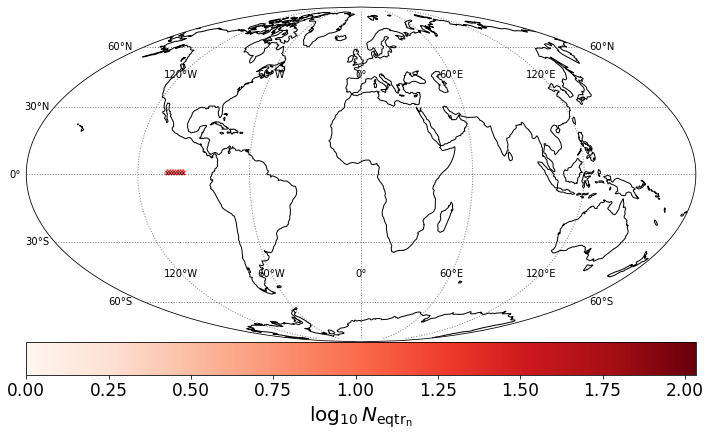

In [13]:
_ = ulmo_figs.show_spatial(viirs_n, lbl = 'eqtr_n')

In [24]:
med = np.abs(viirs_tbl.LL - med_LL_s) < 20
dT = viirs_tbl.dT < 1
viirs_s = viirs_tbl[ eqtr_s & med & dT]
viirs_s

,filename,row,col,lat,lon,clear_fraction,field_size,datetime,ex_filename,pp_file,...,pp_idx,pp_type,mean_temperature,Tmin,Tmax,T90,T10,LL,Year,dT
20705,s3://viirs/data/2012/196/20120714205000-OSPO-L...,624,96,-0.636223,-100.32714,8.409288e-04,192,2012-07-14 20:50:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,88552,0,24.222862,23.399994,25.100006,24.600006,23.799988,568.024170,2012,0.800018
111261,s3://viirs/data/2012/308/20121103205000-OSPO-L...,624,576,-0.552535,-104.25910,8.110894e-03,192,2012-11-03 20:50:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,472277,0,21.396955,20.769989,22.019989,21.679993,21.160004,580.422363,2012,0.519989
134431,s3://viirs/data/2012/321/20121116072000-OSPO-L...,3600,864,-1.514461,-96.33119,2.441406e-03,192,2012-11-16 07:20:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,570692,0,21.777559,20.049988,22.399994,22.160004,21.380005,556.635864,2012,0.779999
175261,s3://viirs/data/2012/211/20120729192000-OSPO-L...,5199,2880,-0.819574,-102.71560,6.998698e-03,192,2012-07-29 19:20:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,744550,0,24.662560,23.000000,25.679993,25.130005,24.250000,567.614441,2012,0.880005
197177,s3://viirs/data/2012/264/20120920193000-OSPO-L...,2928,1920,-0.703025,-96.15211,1.844618e-03,192,2012-09-20 19:30:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,837898,0,21.579498,20.619995,22.239990,21.839996,21.279999,585.420654,2012,0.559998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2191108,s3://viirs/data/2020/139/20200518075000-OSPO-L...,1776,1632,-0.990124,-96.42174,1.437717e-03,192,2020-05-18 07:50:00,s3://viirs/Extractions/VIIRS_2020_95clear_192x...,s3://viirs/PreProc/VIIRS_2020_95clear_192x192_...,...,714790,0,25.380962,23.730011,25.880005,25.630005,25.139984,579.101257,2020,0.490021
2212082,s3://viirs/data/2020/022/20200122202000-OSPO-L...,3888,480,-0.538424,-97.08464,1.437717e-03,192,2020-01-22 20:20:00,s3://viirs/Extractions/VIIRS_2020_95clear_192x...,s3://viirs/PreProc/VIIRS_2020_95clear_192x192_...,...,805392,0,24.693775,23.959991,25.980011,25.250000,24.450012,561.642334,2020,0.799988
2256553,s3://viirs/data/2020/248/20200904070000-OSPO-L...,5199,384,-0.443952,-95.35257,-7.406908e-17,192,2020-09-04 07:00:00,s3://viirs/Extractions/VIIRS_2020_95clear_192x...,s3://viirs/PreProc/VIIRS_2020_95clear_192x192_...,...,998659,0,17.958477,17.299988,18.779999,18.260010,17.679993,570.969910,2020,0.580017
2267420,s3://viirs/data/2020/353/20201218202000-OSPO-L...,528,960,-1.306385,-99.60141,8.409288e-04,192,2020-12-18 20:20:00,s3://viirs/Extractions/VIIRS_2020_95clear_192x...,s3://viirs/PreProc/VIIRS_2020_95clear_192x192_...,...,1046116,0,21.839100,21.209991,22.489990,22.160004,21.519989,554.975830,2020,0.640015


/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


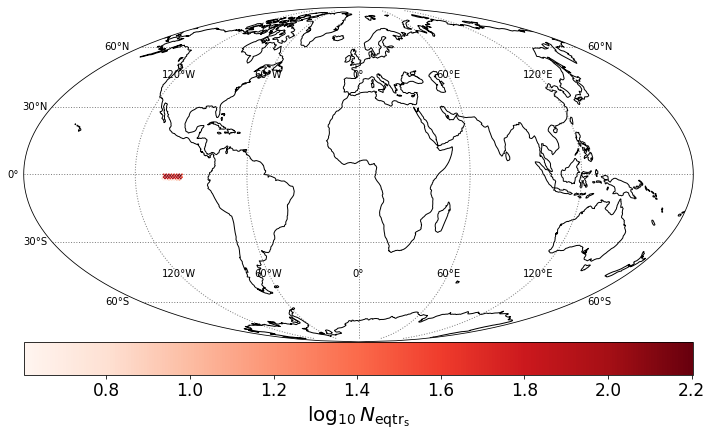

In [15]:
_ = ulmo_figs.show_spatial(viirs_s, lbl = 'eqtr_s')

# ~ Med LL 9 image gallery

In [27]:
pal, cm = plotting.load_palette()

### Equatorial Pacific: LLC

In [43]:
#Generate 9 random numbers from tbl
northlist = np.random.choice( llc_n.index.to_numpy(), size = 9)
print(northlist)

[572743 181912 311055 181906 182278 571230 312931 442830 702645]


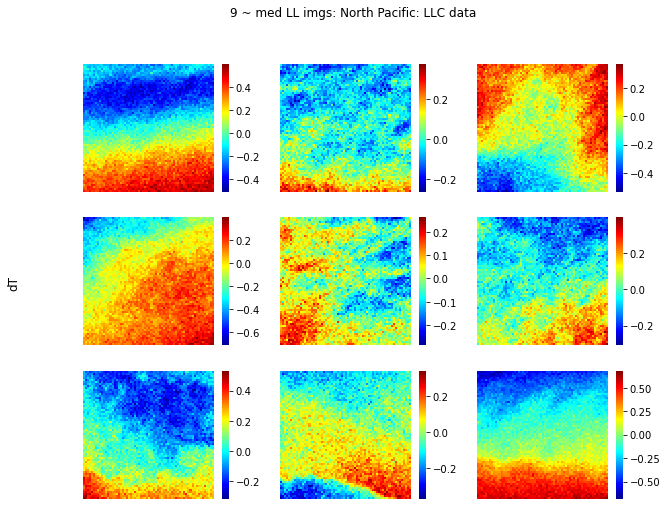

In [44]:
fig, axes = plt.subplots(3, 3, figsize = (10,8) )

fig.suptitle('9 ~ med LL imgs: North Pacific: LLC data')
fig.supylabel('dT')

for i in [0, 1, 2]: 
    
    idx = northlist[ i ] 
    cutout = llc_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax=axes[i, 0], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)
    
for i in [3, 4, 5]: 
    
    idx = northlist[ i ] 
    cutout = llc_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax = axes[i-3, 1], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)
    
for i in [6, 7, 8]: 
    
    idx = northlist[ i ] 
    cutout = llc_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax = axes[i-6, 2], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)  
plt.show()

/tmp/ipykernel_5271/228066219.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


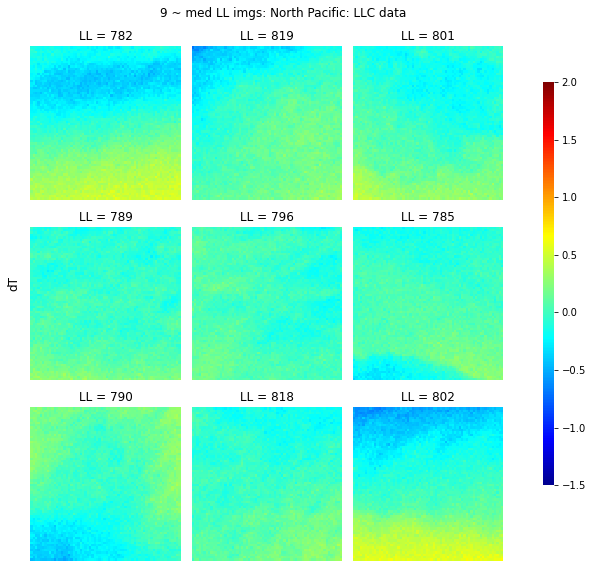

In [45]:
fig, axes = plt.subplots(3, 3, figsize = (8,8) )

fig.suptitle('9 ~ med LL imgs: North Pacific: LLC data')
fig.supylabel('dT')
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
    
for i, ax in enumerate(axes.flat):
    idx = northlist[ i ] 
    cutout = llc_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax=ax, data=img, xticklabels=[], yticklabels=[], cmap=cm,
                cbar=i == 0,
                vmin=-1.5, vmax=2,
                cbar_ax=None if i else cbar_ax)
    ax.set_title('LL = {}'.format(round(cutout.LL)))

fig.tight_layout(rect=[0, 0, .9, 1])


In [40]:
#Generate 9 random numbers from tbl
southlist = np.random.choice( llc_s.index.to_numpy(), size = 9)
print(southlist)

[575316 443953 573477 575316 443571 314043 313304 314041 444312]


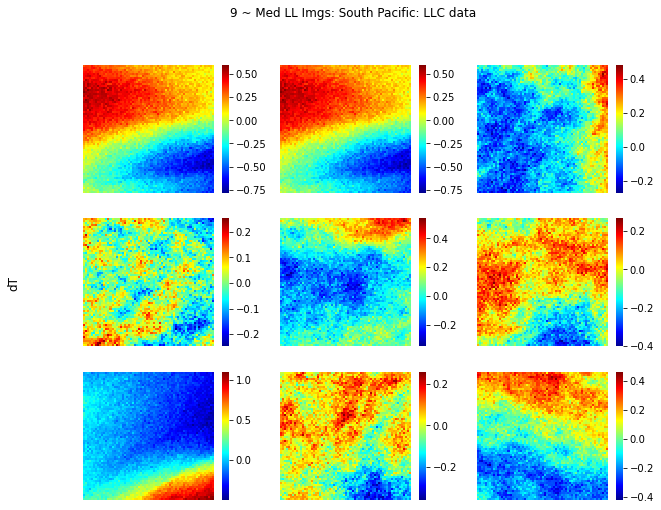

In [41]:
fig, axes = plt.subplots(3, 3, figsize = (10,8) )

fig.suptitle('9 ~ Med LL Imgs: South Pacific: LLC data')
fig.supylabel( 'dT' )

for i in [0, 1, 2]: 
    
    idx = southlist[ i ] 
    cutout = llc_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax=axes[i, 0], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)
    
for i in [3, 4, 5]: 
    
    idx = southlist[ i ] 
    cutout = llc_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax = axes[i-3, 1], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)
    
for i in [6, 7, 8]: 
    
    idx = southlist[ i ] 
    cutout = llc_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax = axes[i-6, 2], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)  
plt.show()
#plt.savefig( 'medLL9_LLC_SP', dpi = 600)

/tmp/ipykernel_5271/3643204673.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


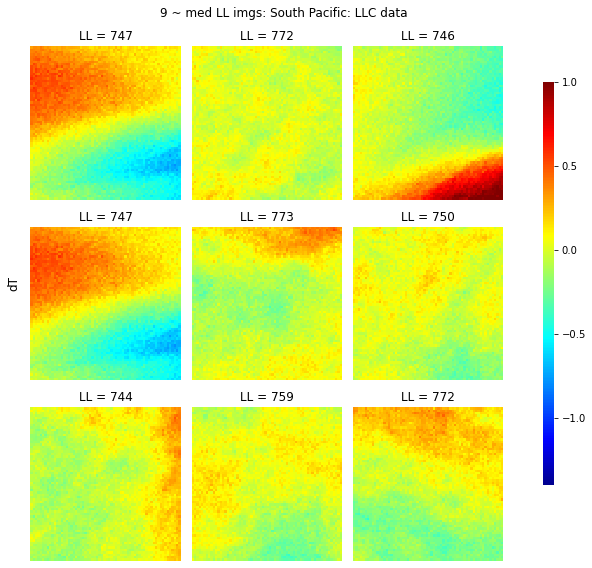

In [46]:
fig, axes = plt.subplots(3, 3, figsize = (8,8) )

fig.suptitle('9 ~ med LL imgs: South Pacific: LLC data')
fig.supylabel('dT')
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
    
for i, ax in enumerate(axes.flat):
    idx = southlist[ i ] 
    cutout = llc_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax=ax, data=img, xticklabels=[], yticklabels=[], cmap=cm,
                cbar=i == 0,
                vmin=-1.4, vmax=1,
                cbar_ax=None if i else cbar_ax)
    ax.set_title('LL = {}'.format(round(cutout.LL)))

fig.tight_layout(rect=[0, 0, .9, 1])

### Equatorial Pacific: VIIRS

In [32]:
#Generate 9 random numbers from tbl
northlist = np.random.choice( viirs_n.index.to_numpy(), size = 9)
print(northlist)

[1130293 1458662  928560 1515135  305910 1120230 1440025 2269603 1334803]


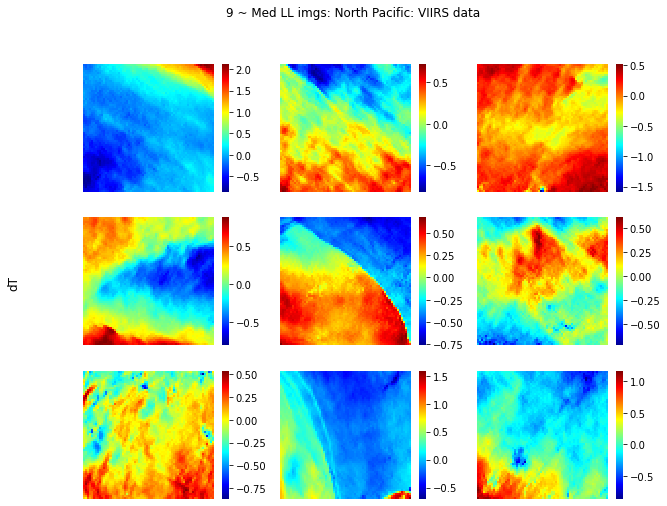

In [33]:
fig, axes = plt.subplots(3, 3, figsize = (10,8) )

fig.suptitle('9 ~ Med LL imgs: North Pacific: VIIRS data')
fig.supylabel('dT')

for i in [0, 1, 2]: 
    
    idx = northlist[ i ] 
    cutout = viirs_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax=axes[i, 0], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)
    
for i in [3, 4, 5]: 
    
    idx = northlist[ i ] 
    cutout = viirs_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax = axes[i-3, 1], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)
    
for i in [6, 7, 8]: 
    
    idx = northlist[ i ] 
    cutout = viirs_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax = axes[i-6, 2], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)  
plt.show()
#plt.savefig( 'medLL9_VIIRS_NP', dpi = 600)

/tmp/ipykernel_5271/2695030377.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


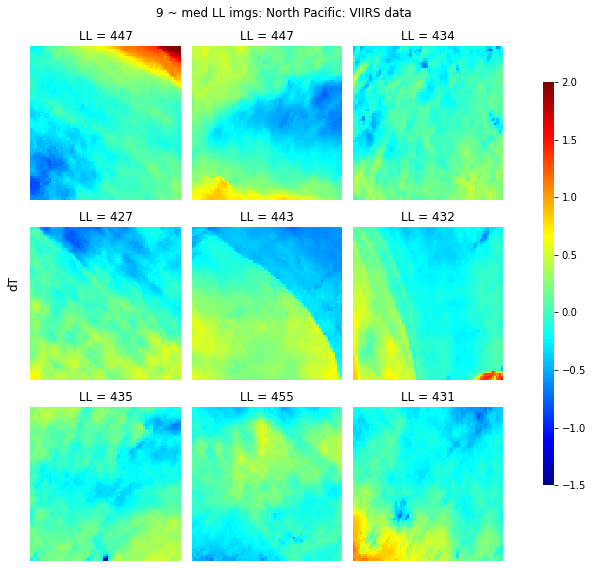

In [35]:
fig, axes = plt.subplots(3, 3, figsize = (8,8) )

fig.suptitle('9 ~ med LL imgs: North Pacific: VIIRS data')
fig.supylabel('dT')
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
    
for i, ax in enumerate(axes.flat):
    idx = northlist[ i ] 
    cutout = viirs_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    name1 = cutout.pp_file.replace('s3://viirs/PreProc/VIIRS_', '')
    year = name1[0:4]
    
    sns.heatmap(ax=ax, data=img, xticklabels=[], yticklabels=[], cmap=cm,
                cbar=i == 0,
                vmin=-1.5, vmax=2,
                cbar_ax=None if i else cbar_ax)
    #ax.set_title('i={}, yr={}'.format(cutout.pp_idx, year))
    ax.set_title('LL = {}'.format(round(cutout.LL)))

fig.tight_layout(rect=[0, 0, .9, 1])

In [48]:
#Generate 9 random numbers from tbl
southlist = np.random.choice( viirs_s.index.to_numpy(), size = 9)
print(southlist)

[ 984541  256812 1118670  693525 1853178  256812 1302303 1417350  665925]


In [49]:
southlist=[ 175261,  655969, 1039844, 2256553, 1158107, 1877559, 256812, 1178359, 1589406]

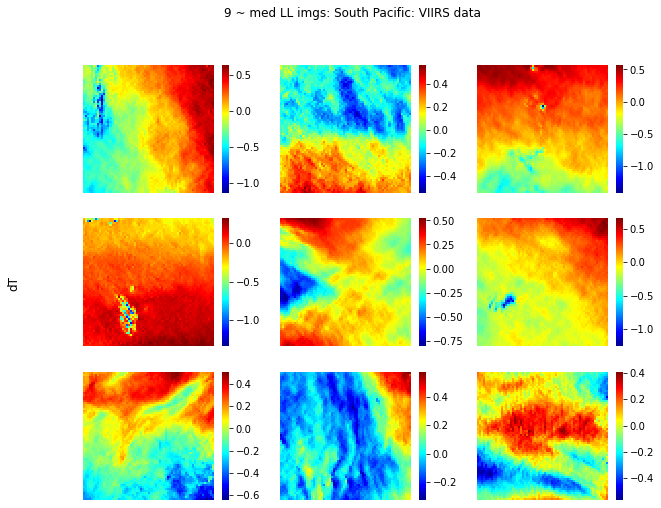

In [37]:
fig, axes = plt.subplots(3, 3, figsize = (10,8) )

fig.suptitle('9 ~ med LL imgs: South Pacific: VIIRS data')
fig.supylabel('dT')

for i in [0, 1, 2]: 
    
    idx = southlist[ i ] 
    cutout = viirs_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax=axes[i, 0], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)
    
for i in [3, 4, 5]: 
    
    idx = southlist[ i ] 
    cutout = viirs_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax = axes[i-3, 1], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)
    
for i in [6, 7, 8]: 
    
    idx = southlist[ i ] 
    cutout = viirs_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax = axes[i-6, 2], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)  
plt.show()
#plt.savefig( 'medLL9_VIIRS_SP', dpi = 600)

/tmp/ipykernel_5271/264188142.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


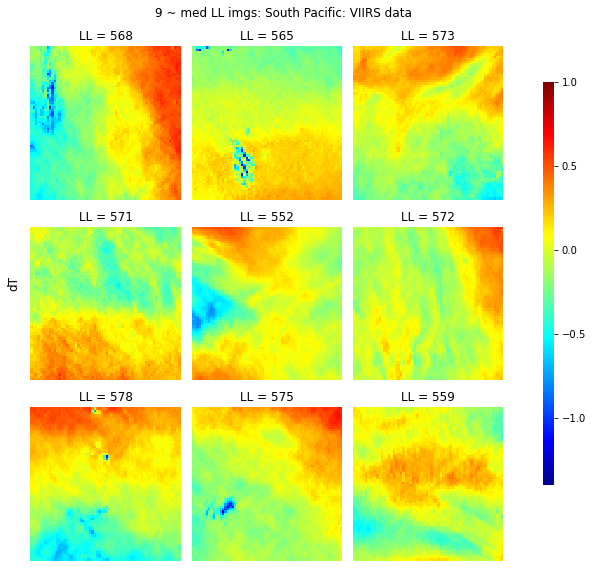

In [51]:
fig, axes = plt.subplots(3, 3, figsize = (8,8) )

fig.suptitle('9 ~ med LL imgs: South Pacific: VIIRS data')
fig.supylabel('dT')
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
    
for i, ax in enumerate(axes.flat):
    idx = southlist[ i ] 
    cutout = viirs_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    name1 = cutout.pp_file.replace('s3://viirs/PreProc/VIIRS_', '')
    year = name1[0:4]
    
    sns.heatmap(ax=ax, data=img, xticklabels=[], yticklabels=[], cmap=cm,
                cbar=i == 0,
                vmin=-1.4, vmax=1,
                cbar_ax=None if i else cbar_ax)
    #ax.set_title('i={}, yr={}'.format(cutout.pp_idx, year))
    ax.set_title('LL = {}'.format(round(cutout.LL)))

fig.tight_layout(rect=[0, 0, .9, 1])

### 60W : LLC

In [192]:
R1list = np.random.choice( llc1.index.to_numpy(), size = 9)
print(R1list)

[238933 628402 760041 104478 109104 496258 627475 496258 628402]


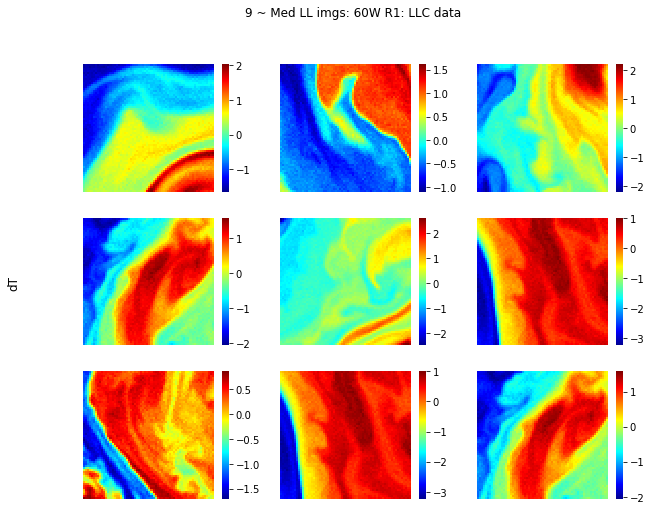

In [193]:
fig, axes = plt.subplots(3, 3, figsize = (10,8) )

fig.suptitle('9 ~ Med LL imgs: 60W R1: LLC data')
fig.supylabel('dT')

for i in [0, 1, 2]: 
    
    idx = R1list[ i ] 
    cutout = llc_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax=axes[i, 0], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)
    
for i in [3, 4, 5]: 
    
    idx = R1list[ i ] 
    cutout = llc_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax = axes[i-3, 1], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)
    
for i in [6, 7, 8]: 
    
    idx = R1list[ i ] 
    cutout = llc_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax = axes[i-6, 2], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)  
plt.show()
#plt.savefig( 'medLL9_LLC_60W_R1', dpi = 600)

/tmp/ipykernel_5110/729330121.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


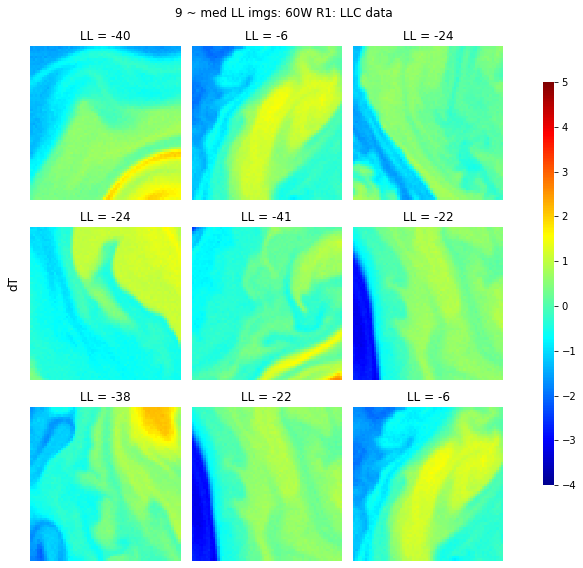

In [194]:
fig, axes = plt.subplots(3, 3, figsize = (8,8) )

fig.suptitle('9 ~ med LL imgs: 60W R1: LLC data')
fig.supylabel('dT')
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
    
for i, ax in enumerate(axes.flat):
    idx = R1list[ i ] 
    cutout = llc_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    name1 = cutout.pp_file.replace('s3://viirs/PreProc/VIIRS_', '')
    year = name1[0:4]
    
    sns.heatmap(ax=ax, data=img, xticklabels=[], yticklabels=[], cmap=cm,
                cbar=i == 0,
                vmin=-4, vmax=5,
                cbar_ax=None if i else cbar_ax)
    #ax.set_title('i={}, yr={}'.format(cutout.pp_idx, year))
    ax.set_title('LL = {}'.format(round(cutout.LL)))

fig.tight_layout(rect=[0, 0, .9, 1])

In [195]:
R2list = np.random.choice( llc2.index.to_numpy(), size = 9)
print(R2list)

[760034 760481 760034 497656 760481 760481 365975 629308 626057]


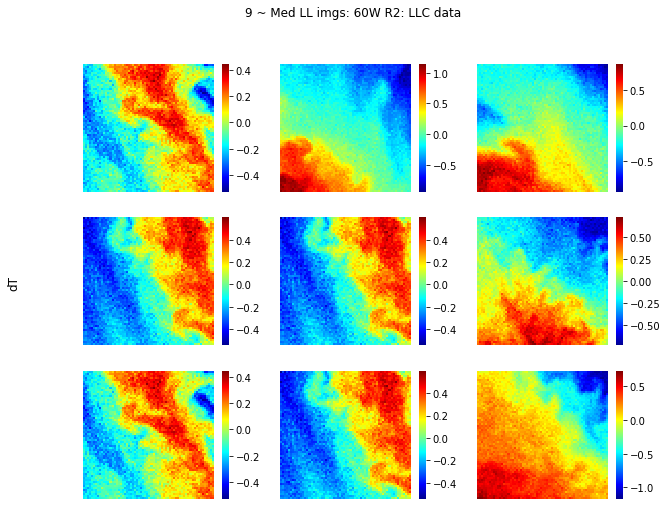

In [197]:
fig, axes = plt.subplots(3, 3, figsize = (10,8) )

fig.suptitle('9 ~ Med LL imgs: 60W R2: LLC data')
fig.supylabel('dT')

for i in [0, 1, 2]: 
    
    idx = R2list[ i ] 
    cutout = llc_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax=axes[i, 0], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)
    
for i in [3, 4, 5]: 
    
    idx = R2list[ i ] 
    cutout = llc_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax = axes[i-3, 1], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)
    
for i in [6, 7, 8]: 
    
    idx = R2list[ i ] 
    cutout = llc_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax = axes[i-6, 2], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)  
plt.show()
#plt.savefig( 'medLL9_LLC_60W_R2', dpi = 600)

/tmp/ipykernel_5110/2214951145.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


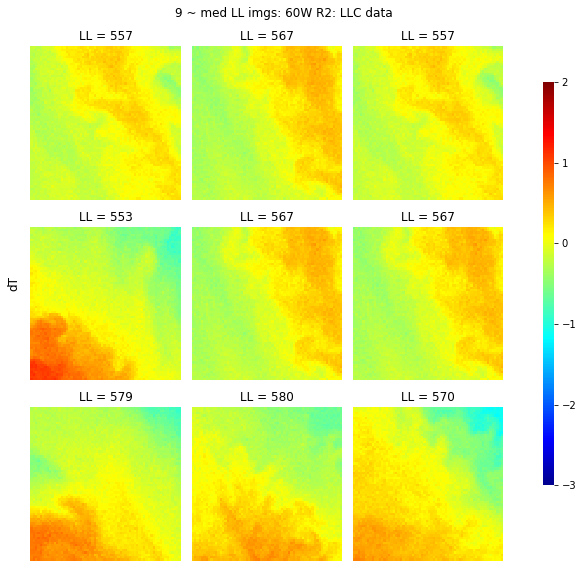

In [198]:
fig, axes = plt.subplots(3, 3, figsize = (8,8) )

fig.suptitle('9 ~ med LL imgs: 60W R2: LLC data')
fig.supylabel('dT')
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
    
for i, ax in enumerate(axes.flat):
    idx = R2list[ i ] 
    cutout = llc_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    name1 = cutout.pp_file.replace('s3://viirs/PreProc/VIIRS_', '')
    year = name1[0:4]
    
    sns.heatmap(ax=ax, data=img, xticklabels=[], yticklabels=[], cmap=cm,
                cbar=i == 0,
                vmin=-3, vmax=2,
                cbar_ax=None if i else cbar_ax)
    #ax.set_title('i={}, yr={}'.format(cutout.pp_idx, year))
    ax.set_title('LL = {}'.format(round(cutout.LL)))

fig.tight_layout(rect=[0, 0, .9, 1])

### 60W : VIIRS

In [184]:
R1list = np.random.choice( viirs1.index.to_numpy(), size = 9)
print(R1list)

[1569500 2147957 1857920  337872 1992599 1840121  657531  721836 1396113]


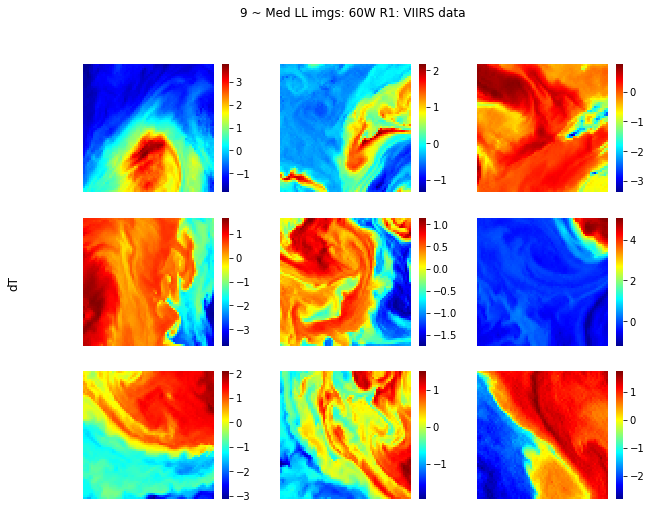

In [186]:
fig, axes = plt.subplots(3, 3, figsize = (10,8) )

fig.suptitle('9 ~ Med LL imgs: 60W R1: VIIRS data')
fig.supylabel('dT')

for i in [0, 1, 2]: 
    
    idx = R1list[ i ] 
    cutout = viirs_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax=axes[i, 0], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)
    
for i in [3, 4, 5]: 
    
    idx = R1list[ i ] 
    cutout = viirs_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax = axes[i-3, 1], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)
    
for i in [6, 7, 8]: 
    
    idx = R1list[ i ] 
    cutout = viirs_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax = axes[i-6, 2], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)  
plt.show()
#plt.savefig( 'medLL9_VIIRS_60W_R1', dpi = 600)

/tmp/ipykernel_5110/295316508.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


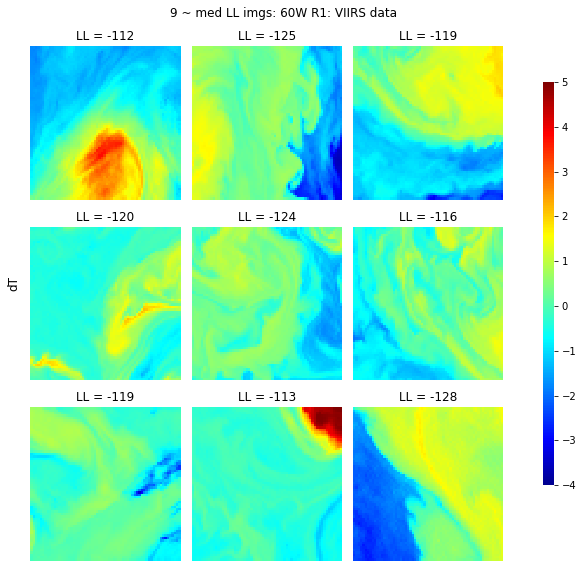

In [187]:
fig, axes = plt.subplots(3, 3, figsize = (8,8) )

fig.suptitle('9 ~ med LL imgs: 60W R1: VIIRS data')
fig.supylabel('dT')
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
    
for i, ax in enumerate(axes.flat):
    idx = R1list[ i ] 
    cutout = viirs_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    name1 = cutout.pp_file.replace('s3://viirs/PreProc/VIIRS_', '')
    year = name1[0:4]
    
    sns.heatmap(ax=ax, data=img, xticklabels=[], yticklabels=[], cmap=cm,
                cbar=i == 0,
                vmin=-4, vmax=5,
                cbar_ax=None if i else cbar_ax)
    #ax.set_title('i={}, yr={}'.format(cutout.pp_idx, year))
    ax.set_title('LL = {}'.format(round(cutout.LL)))

fig.tight_layout(rect=[0, 0, .9, 1])

In [188]:
R2list = np.random.choice( viirs2.index.to_numpy(), size = 9)
print(R2list)

[1654190 2261961  601751 1378681  505295 2001485 1284707  422415 2009697]


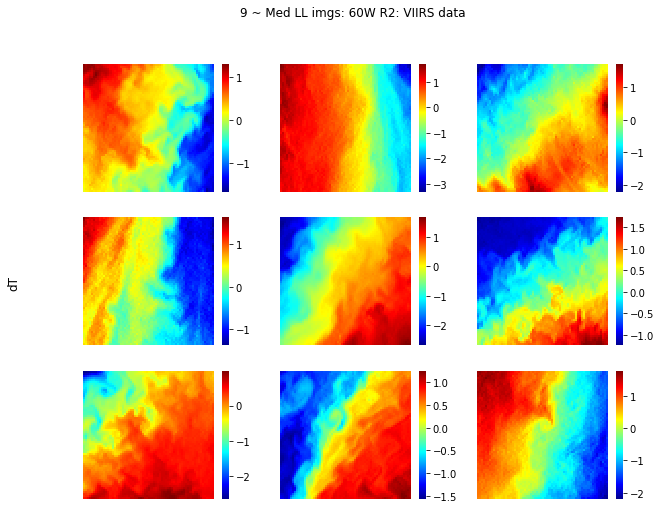

In [190]:
fig, axes = plt.subplots(3, 3, figsize = (10,8) )

fig.suptitle('9 ~ Med LL imgs: 60W R2: VIIRS data')
fig.supylabel('dT')

for i in [0, 1, 2]: 
    
    idx = R2list[ i ] 
    cutout = viirs_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax=axes[i, 0], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)
    
for i in [3, 4, 5]: 
    
    idx = R2list[ i ] 
    cutout = viirs_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax = axes[i-3, 1], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)
    
for i in [6, 7, 8]: 
    
    idx = R2list[ i ] 
    cutout = viirs_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax = axes[i-6, 2], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)  
plt.show()
#plt.savefig( 'medLL9_LLC_60W_R2', dpi = 600)

/tmp/ipykernel_5110/3205390346.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


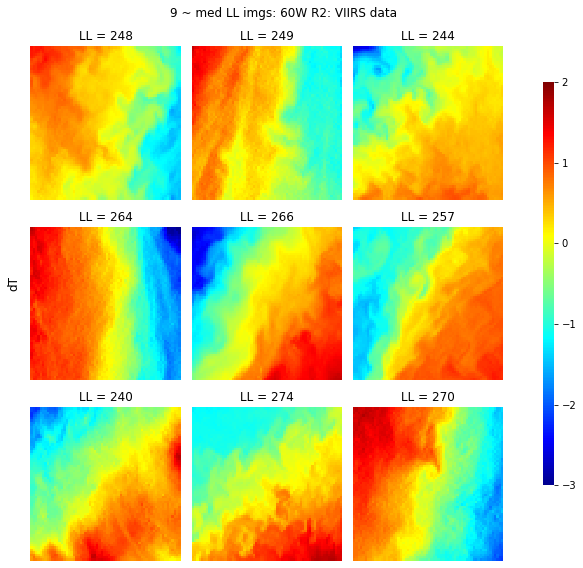

In [191]:
fig, axes = plt.subplots(3, 3, figsize = (8,8) )

fig.suptitle('9 ~ med LL imgs: 60W R2: VIIRS data')
fig.supylabel('dT')
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
    
for i, ax in enumerate(axes.flat):
    idx = R2list[ i ] 
    cutout = viirs_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    name1 = cutout.pp_file.replace('s3://viirs/PreProc/VIIRS_', '')
    year = name1[0:4]
    
    sns.heatmap(ax=ax, data=img, xticklabels=[], yticklabels=[], cmap=cm,
                cbar=i == 0,
                vmin=-3, vmax=2,
                cbar_ax=None if i else cbar_ax)
    #ax.set_title('i={}, yr={}'.format(cutout.pp_idx, year))
    ax.set_title('LL = {}'.format(round(cutout.LL)))

fig.tight_layout(rect=[0, 0, .9, 1])